In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models, datasets
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sn
from sklearn.metrics import classification_report, confusion_matrix

from resnet import ResNet
from unet import UNet
from utils import *

In [2]:
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

True
0
1
NVIDIA GeForce GTX 1070


In [3]:
num_180 = 0
num_166 = 0
num_162 = 0
num_other = 0

cls_num_list_train = [0,0,0]
cls_num_list_test = [0,0,0]
n = 0
bigmat_train = []
bigmat_test = []

for folder in ["train","test"]:
    for cls_idx,subfolder in enumerate(["AD","CN","MCI"]):
        files = os.listdir('MRI_all/' + folder + '/' + subfolder)
        
        for file in files:
            mat = np.load('MRI_all/' + folder + '/' + subfolder + '/' + file)
            
            if folder=="train":
                # bigmat_train.append(mat)
                n += 1
                cls_num_list_train[cls_idx] += 1
            if folder=="test":
                # bigmat_test.append(mat)
                cls_num_list_test[cls_idx] +=1
            
            # print(folder, subfolder, file, mat.shape)
            if(mat.shape[0] == 162):
                num_162 += 1
            else:
                num_other += 1
            # np.save(folder + '/' + subfolder + '/' + file, mat)

In [4]:
# !rm -R MRI_all/train/.ipynb_checkpoints
# !rm -R MRI_all/test/.ipynb_checkpoints
# !ls train -a
# !ls test -a

In [5]:
print(num_166, num_180, num_162)
print(cls_num_list_train, cls_num_list_test)

0 0 1624
[207, 483, 607] [38, 127, 162]


In [5]:
# bigmat_train = np.stack(bigmat_train)
# print(bigmat_train.shape)
# bigmat_test = np.stack(bigmat_test)
# print(bigmat_test.shape)

(1297, 162, 256, 256)
(327, 162, 256, 256)


In [65]:
# np.save("bigmat_MRI.npy",bigmat)
# np.save("bigmat_test_MRI.npy",bigmat_test)

In [9]:
# file_idx = 110

# plt.figure(figsize=(15,15))
# for idx in range(162):
#     plt.subplot(12,15,idx+1)
#     plt.imshow(bigmat_train[file_idx,idx,:,:],cmap='gray')
#     plt.xticks([]);plt.yticks([])
# plt.show()

In [10]:
# !ls train/CN -a

In [6]:
# bigmat = bigmat/255
# mean_list = np.mean(bigmat,axis=(0,2,3))/255
# std_list = np.std(bigmat,axis=(0,2,3))/255

mean_list = np.load("MRI_mean.npy")
std_list = np.load("MRI_std.npy")

In [7]:
transform_train = transforms.Compose([transforms.ToTensor(),
                                     transforms.RandomCrop(256, padding=16),
                                     # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0, hue=0),
                                     transforms.GaussianBlur(kernel_size = (5,5), sigma=(0.2,0.2)),
                                     transforms.Normalize(mean_list, std_list)
                                    ])
transform_test = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean_list, std_list)])

def npy_loader_train(path):
    mat = np.load(path)
    mat = np.transpose(mat, (1,2,0))
    mat = transform_train(mat)
    return mat

def npy_loader_test(path):
    mat = np.load(path)
    mat = np.transpose(mat, (1,2,0))
    mat = transform_test(mat)
    return mat

trainset = datasets.DatasetFolder(root="MRI_all/train", loader=npy_loader_train, extensions=(".npy"))
testset = datasets.DatasetFolder(root="MRI_all/test", loader=npy_loader_test, extensions=(".npy"))

trainloader = DataLoader(trainset, batch_size=2, shuffle=True)
testloader = DataLoader(testset, batch_size=2, shuffle=False)

In [ ]:
# for x,y in trainloader:
#     print(x)
#     break

## Model

In [8]:
# model = ResNet(in_channels= 162, num_classes=3)
model = UNet(in_channels=162, num_classes=3)

print(sum(p.numel() for p in model.parameters())/1000000, "M parameters")
x = torch.randn(1,162,256,256)
model(x)

31.154291 M parameters


tensor([[ 0.0789, -0.2097,  0.2809]], grad_fn=<AddmmBackward0>)

## Training

In [9]:
per_cls_weights = [0.5,0.3,0.2]
criterion = nn.CrossEntropyLoss(weight=torch.tensor(per_cls_weights)) # CE Loss, Takes care of applying softmax

# per_cls_weights = reweight(cls_num_list_train, beta=0.999)
# criterion = FocalLoss(weight=per_cls_weights, gamma=2)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # Adam optimizer
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4) # SGD
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

model = model.to(device)
criterion = criterion.to(device)

In [10]:
train_loss_list = []
test_loss_list = []

for epoch in range(25):  # num epochs
    
    # Training
    model.train() # Set to train mode
    running_loss = 0.0
    running_corrects = 0

    for i, data in enumerate(trainloader): # Get data batch-wise
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # print(inputs.shape, inputs.dtype)
        # labels = labels.type(torch.LongTensor)

        # zero out gradients
        optimizer.zero_grad()

        outputs = model(inputs) # forward pass
        # print(outputs.shape, labels.shape)
        loss = criterion(outputs, labels) # Get loss
        loss.backward() # Backward pass
        optimizer.step() # Optimize model weights

        _, preds = torch.max(outputs, 1) # Get predictions
        running_loss += loss.detach() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    # Get loss and accuracy
    train_loss = (running_loss / len(trainset))
    train_loss_list.append(train_loss.item())
    train_accuracy = (running_corrects.float() / len(trainset))

    # Testing
    model.eval() # Set to eval mode
    running_loss = 0.0
    running_corrects = 0
    y = []; yhat = []

    for i, data in enumerate(testloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # labels = labels.type(torch.LongTensor)

        # forward + backward + optimize
        with torch.no_grad(): # Don't build computation graph for testing
            outputs = model(inputs)
        # print(outputs.shape, labels.shape)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)
        y.append(labels.tolist())
        yhat.append(preds.tolist())
        running_loss += loss.detach() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    scheduler.step() # Update lr
    
    # Get loss and accuracy
    test_loss = (running_loss / len(testset))
    test_loss_list.append(test_loss.item())
    test_accuracy = (running_corrects.float() / len(testset))

    # Display loss, accuracy values after each epoch
    print("Epoch:{} | Train loss: {:.4f} | Test loss: {:.4f} | Train acc.: {:.4f} | Test acc.: {:.4f}\n"
              .format(epoch, train_loss.item(),test_loss.item(),train_accuracy.item(),test_accuracy.item()))


Epoch:0 | Train loss: 1.1107 | Test loss: 1.0179 | Train acc.: 0.4256 | Test acc.: 0.4954

Epoch:1 | Train loss: 1.0657 | Test loss: 1.0076 | Train acc.: 0.4395 | Test acc.: 0.3884

Epoch:2 | Train loss: 1.0603 | Test loss: 1.0147 | Train acc.: 0.4387 | Test acc.: 0.3884

Epoch:3 | Train loss: 1.0611 | Test loss: 1.0116 | Train acc.: 0.4348 | Test acc.: 0.3884

Epoch:4 | Train loss: 1.0631 | Test loss: 0.9863 | Train acc.: 0.3855 | Test acc.: 0.4954

Epoch:5 | Train loss: 1.0578 | Test loss: 1.0196 | Train acc.: 0.4541 | Test acc.: 0.3884

Epoch:6 | Train loss: 1.0623 | Test loss: 1.0148 | Train acc.: 0.4009 | Test acc.: 0.3884

Epoch:7 | Train loss: 1.0607 | Test loss: 1.0023 | Train acc.: 0.4079 | Test acc.: 0.4954

Epoch:8 | Train loss: 1.0618 | Test loss: 0.9956 | Train acc.: 0.4279 | Test acc.: 0.3884

Epoch:9 | Train loss: 1.0624 | Test loss: 1.0034 | Train acc.: 0.4079 | Test acc.: 0.4954

Epoch:10 | Train loss: 1.0604 | Test loss: 0.9954 | Train acc.: 0.4040 | Test acc.: 0.4954

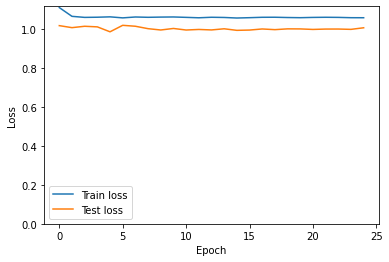

In [11]:
# Loss curves
plt.plot(train_loss_list)
plt.plot(test_loss_list)
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.ylim(bottom = 0)
plt.legend(["Train loss", "Test loss"])
plt.show()

## Evaluation

In [12]:
y = np.hstack(y)
yhat = np.hstack(yhat)
print(classification_report(y, yhat, target_names=trainset.classes, digits=4))

              precision    recall  f1-score   support

          AD     0.0000    0.0000    0.0000        38
          CN     0.0000    0.0000    0.0000       127
         MCI     0.4954    1.0000    0.6626       162

    accuracy                         0.4954       327
   macro avg     0.1651    0.3333    0.2209       327
weighted avg     0.2454    0.4954    0.3282       327



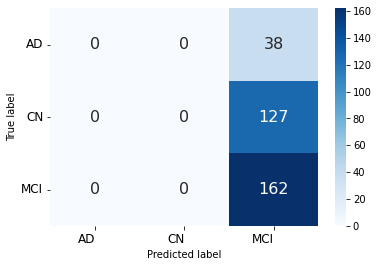

In [13]:
cm=confusion_matrix(y,yhat)
class_names=trainset.classes
#     print(cm)

# Enhanced confusion matrix
plt.figure(figsize=(6,4))
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names).astype(int)
heatmap = sn.heatmap(df_cm, cmap="Blues", annot=True, fmt="d", annot_kws={'size':16})

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=12)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right',fontsize=12)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [36]:
# Save model
# torch.save(model.state_dict(), "checkpoint/" + "ResNet.pth")

In [ ]:
# Load
# model.load_state_dict(torch.load("checkpoint/" + "DNN.pth"))
# model.eval()

In [13]:
# import shutil

In [15]:
# shutil.make_archive('/MRI_all',
#                     'zip')